# The Requests Library

Now that we know how to use BeautifulSoup to get data from HTML files, let's see how we can scrape data from a real website. Unfortunately, Beautifulsoup can't access websites directly. Therefore, in order to access websites, we will use Python's `requests` library. The `requests` library allows us to send web requests and get a website's HTML data. Once the `requests` library gets us the HTML data, we can use Beautifulsoup, just as we did before, to extract the data we want. So let's see an example.

In the code below we will use the `requests` library and BeautifulSoup to get Tesla's `production and sales by quarter` data from a `html table` the following Wikipedia [webpage](https://en.wikipedia.org/wiki/Tesla,_Inc.). This table corresponds to Tesla's production and sales figures since Q1 2013. We will start by importing the `requests` library by using:

```python
import requests
```

We will then use the `requests.get(website)` function to get the source code from our `wikipage`. The `requests.get()` function returns a `Response` object that we will save in the variable `r`. We can get the HTML data we need from this object by using the `.text` method, as shown below. Finally, we'll convert and display the extracted html table into Pandas dataframe.

In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nmaiorana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
news_tables = {}
tickers = ['TLRY', 'OMP', 'HBORF', 'WKHS']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    try:
        response = urlopen(req)    
    except:
        continue
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [28]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['TLRY']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Robinhood's Most Popular Marijuana Stocks Ranked From Best to Worst
May-21-21 06:02AM  
Tilray Just Got A Lot Bigger  So Is The Pot Stock A Buy?
May-20-21 06:19PM  
Canadian Cannabis Tilray Stock Earns Relative Strength Rating Upgrade
May-18-21 01:48PM  
The Single Most Exciting Mental Health Breakthrough Of The Decade?
May-17-21 05:00PM  


In [29]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news[:5]

[['TLRY',
  'May-21-21',
  '06:02AM',
  "Robinhood's Most Popular Marijuana Stocks Ranked From Best to Worst"],
 ['TLRY',
  'May-20-21',
  '06:19PM',
  'Tilray Just Got A Lot Bigger  So Is The Pot Stock A Buy?'],
 ['TLRY',
  'May-18-21',
  '01:48PM',
  'Canadian Cannabis Tilray Stock Earns Relative Strength Rating Upgrade'],
 ['TLRY',
  'May-17-21',
  '05:00PM',
  'The Single Most Exciting Mental Health Breakthrough Of The Decade?'],
 ['TLRY',
  'May-17-21',
  '11:16AM',
  'Are Any Canadian Marijuana Stocks Good Buys As Earnings Disappoint?']]

In [30]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,compound,neg,neu,pos
0,TLRY,2021-05-21,06:02AM,Robinhood's Most Popular Marijuana Stocks Rank...,0.4927,0.223,0.381,0.397
1,TLRY,2021-05-20,06:19PM,Tilray Just Got A Lot Bigger So Is The Pot St...,0.0000,0.000,1.000,0.000
2,TLRY,2021-05-18,01:48PM,Canadian Cannabis Tilray Stock Earns Relative ...,0.4939,0.000,0.714,0.286
3,TLRY,2021-05-17,05:00PM,The Single Most Exciting Mental Health Breakth...,0.5413,0.000,0.720,0.280
4,TLRY,2021-05-17,11:16AM,Are Any Canadian Marijuana Stocks Good Buys As...,0.0516,0.199,0.588,0.213


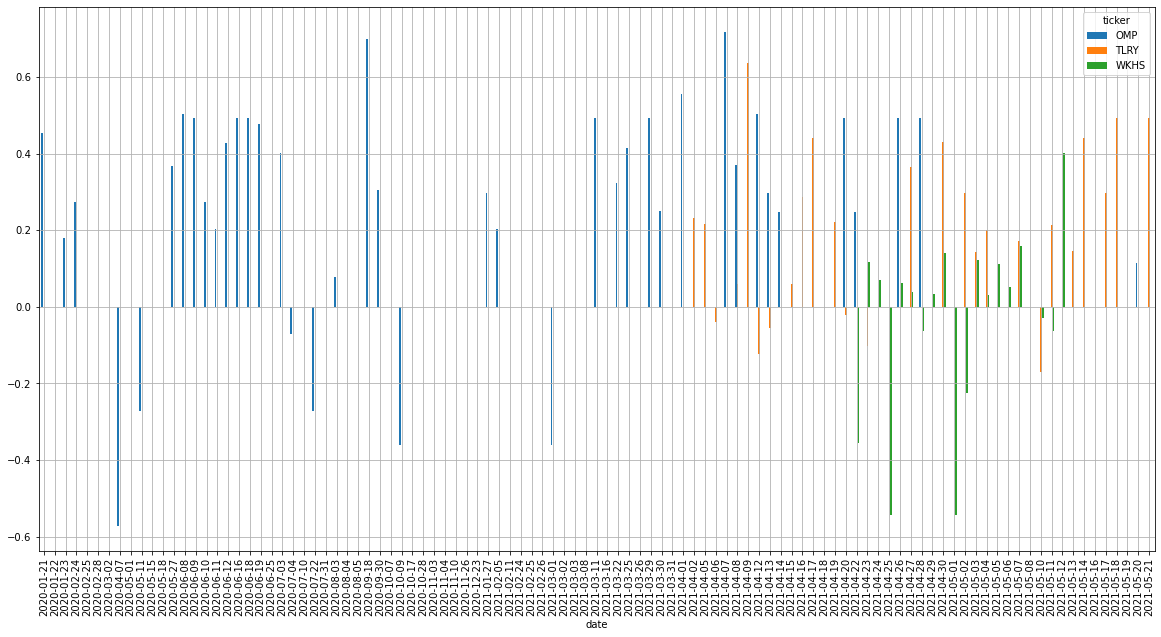

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()